In [1]:
import pandas as pd
import glob
from scipy.stats import chi2_contingency, fisher_exact, chisquare
import matplotlib.pyplot as  plt
import numpy as np

In [2]:
feature_intervals = {
        'aspect': np.arange(0, 370, 10),
        'slope' :  np.arange(0, 70, 2),
        #'forest-height': np.arange(0, 60, 1),
        'elevation': np.arange(0, 650, 10),
        'tree-cover' : np.arange(20, 105, 2),
        'curvature': np.arange(-13, 13, 0.5),
        'curvature-plan': np.arange(-13, 13, 0.5),
        'curvature-prof': np.arange(-13, 13, 0.5),
        'patches': np.array([0, 10, 100, 1000, 10000, 100000, 1000000, 10000000]),
        #'patches': np.array([0]+[np.exp(j) for j in range(1, 16)]),
        'morphology': np.arange(0, 12, 1)
    }
prefix = 'total'

## Column-wise sum tests

In [3]:
features = ['elevation', 'aspect', 'slope', 'tree-cover', 'morphology', 'curvature', 'curvature-prof', 'curvature-plan']
for feature in features:
    result = (pd.read_csv(f'./wfallcorr-final-lg/{prefix}_0.4_{feature}.csv').loc[:, 'pr'] - sum([pd.read_csv(f'./wfallcorr-final-lg/{prefix}_0.4_{feature}_{j}.csv').loc[:, 'dist'] for j in range(1, 8)]).values[1:]).sum()
    print(f"Sum testing ... {feature}: {'Consistent' if result == 0 else 'Inconsistent'}  ")
    if result != 0:
        break
else:
    print("Column-wise sums are consistent.")

Sum testing ... elevation: Consistent  
Sum testing ... aspect: Consistent  
Sum testing ... slope: Consistent  
Sum testing ... tree-cover: Consistent  
Sum testing ... morphology: Consistent  
Sum testing ... curvature: Consistent  
Sum testing ... curvature-prof: Consistent  
Sum testing ... curvature-plan: Consistent  
Column-wise sums are consistent.


In [4]:
for feature in features: 
    print(feature, pd.read_csv(f'./wfallcorr-final-lg/{prefix}_0.4_{feature}.csv').loc[:, 'pr'].sum())
              

elevation 150679166
aspect 150679166
slope 150679166
tree-cover 149827139
morphology 150679166
curvature 150679166
curvature-prof 150679166
curvature-plan 150679166


### Applying chi-squre test for contingency tables

In [5]:
for feature in features:
    table = pd.read_csv(f'./wfallcorr-final-lg/{prefix}_0.4_{feature}.csv').loc[:, ['pr','ft']].values
    table = table[table.sum(axis=1) != 0]   # drop complete zero-rows
    print(f"Applying chi2-test to the feature: {feature}; p-val = {chi2_contingency(table)[1]}.")
    #table = table / table.sum(axis=0)
    #print(f"Applying ch2-test to frequencies, shape={table.shape}: p-val = {chisquare(table[:,0], table[:,1])[1]} ")

Applying chi2-test to the feature: elevation; p-val = 0.0.
Applying chi2-test to the feature: aspect; p-val = 0.0.
Applying chi2-test to the feature: slope; p-val = 0.0.
Applying chi2-test to the feature: tree-cover; p-val = 0.0.
Applying chi2-test to the feature: morphology; p-val = 0.0.
Applying chi2-test to the feature: curvature; p-val = 0.0.
Applying chi2-test to the feature: curvature-prof; p-val = 0.0.
Applying chi2-test to the feature: curvature-plan; p-val = 0.0.


In [6]:
from scipy.stats import chi2_contingency, chisquare, norm

In [13]:

@np.vectorize
def safe_sqrt(x):
    res = np.sqrt(x)
    if np.isnan(res):
        return 1
    else:
        return res / np.sqrt(x)

In [71]:
class r_obj:
    def ppf(self, w, alpha=0.05):
        n = len(w)
        gamma = w/max(w)
        res=2*(0.1+np.random.rand(n))*gamma*alpha**2
        #res[(w-res)<0] = w[(w-res)<0]
        #breakpoint()
        return res
r = r_obj()

In [72]:
def save_to_file(fname, what, title):
    with open(fname, "a+") as f:
        f.write(f"\n{title}\n")
        for item in what:
            f.write(f"{item}\n")
            

In [73]:
def get_low_up(l, u):
    low, up = [],[]
    for a,b in zip(l, u):
        up.append(max(a,b))
        low.append(min(a,b))
    return np.array(low), np.array(up)

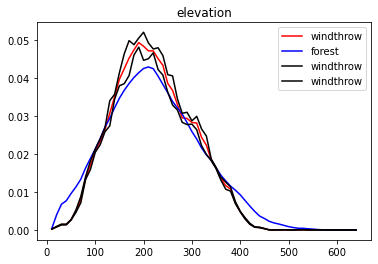

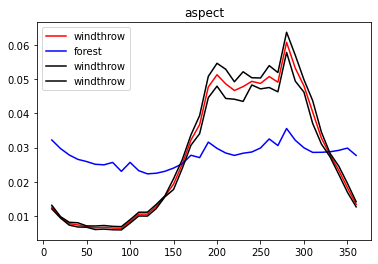

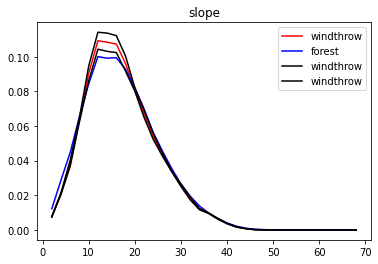

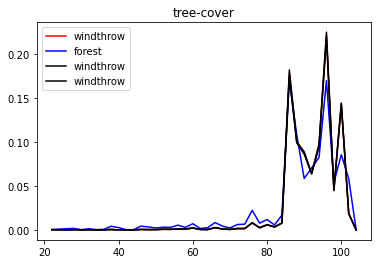

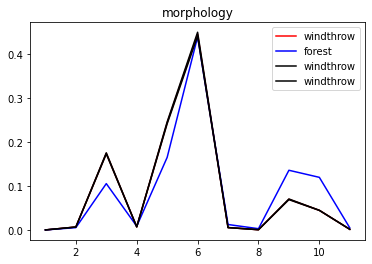

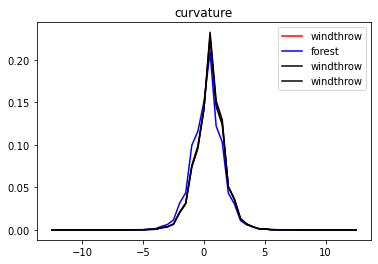

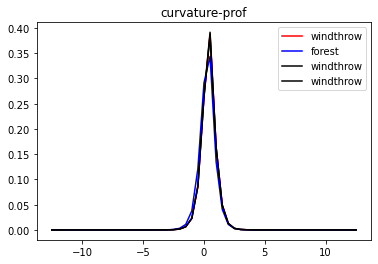

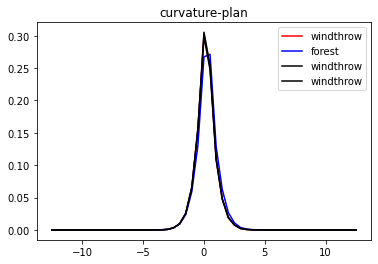

In [74]:
import os
try:
    os.remove('results.txt')
except:
    ...

for feature in features:
    data=pd.read_csv(f'./wfallcorr-final-lg/{prefix}_0.4_{feature}.csv')
    plt.figure()
    plt.plot(feature_intervals[feature][1:], data.pr/data.pr.sum(), 'r', label='windthrow')
    plt.plot(feature_intervals[feature][1:], data.ft/data.ft.sum(), 'b', label='forest')
    nwindthrow = data.pr.sum()
    nforest = data.ft.sum()
    
    w = data.pr/data.pr.sum()
    #breakpoint()
    d = r.ppf(w)
#     print(f"Lower-bound {feature}, windthrow:\n", w-d)
#     print(f"Upper-bound {feature}, windthrow:\n", w+d)
    low, up = get_low_up(w-d, w+d)
    plt.plot(feature_intervals[feature][1:], low, 'k', label='windthrow')
    plt.plot(feature_intervals[feature][1:], up, 'k', label='windthrow')
    save_to_file("results.txt", low, f"Lower-bound {feature}, windthrow:")
    save_to_file("results.txt", up, f"Upper-bound {feature}, windthrow:")
    
    z = data.ft/data.ft.sum()
    #breakpoint()
    d = r.ppf(z)
    low, up = get_low_up(z-d, z+d)
    save_to_file("results.txt", low, f"Lower-bound {feature}, forest:")
    save_to_file("results.txt", up, f"Upper-bound {feature}, forest:")
    
    plt.title(f"{feature}")
    plt.legend()
#     if feature == 'aspect':
#         plt.figure()
#         plt.polar(feature_intervals[feature][1:]/180*np.pi, data.pr/data.pr.sum(), 'r', label='windthrow')
#         plt.polar(feature_intervals[feature][1:]/180*np.pi, data.ft/data.ft.sum(), 'b', label='forest')
#         plt.title(f"{feature}")
#         plt.legend()
    

In [75]:
from scipy import stats as st

In [ ]:
r=st.norm(loc=0, scale=1)

In [ ]:
r.ppf(0.95/2+0.5)